# How does a neural net really work?

NN - neural network
<br>

## Fitting a function with gradient accent

A neural network is just a math function. In the most standart kind of NN, the function
1. Multiplies each input by a number of values. These values are known as *parameters*
2. Adds them up for each group of values
3. Replaces the negative with zeros

This represents one "layer". These steps are repeated using the outputs of the previous layer as the inputs of the next. \
Initial parameters are random => newly created NN can't do anything usefull. \
To make the function "learn" we have to change the parameters to make them "better". To do that we use gradient descent.

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plotFunction(f, title=None, min=-2.1, max = 2.1, color='r', ylim=None):
    x = torch.linspace(min, max, 100)[:, None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

Lets fit a quadratic equation

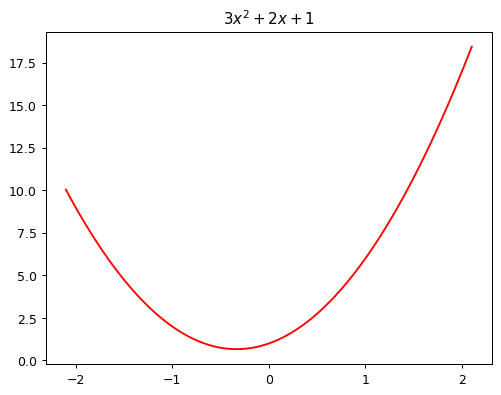

In [2]:
def f(x): return 3*x**2 + 2*x + 1

plotFunction(f, "$3x^2 + 2x + 1$")

Quadratic: $ax^2 + bx + c$. <br>
To make it easier to try different values lets create a function that computes a value of a point in ANY quadratic

In [3]:
def quad(a, b, c, x): return a*x**2 + b*x + c

Lets fix some values

In [4]:
def mk_quad(a, b, c): return partial(quad, a, b, c)

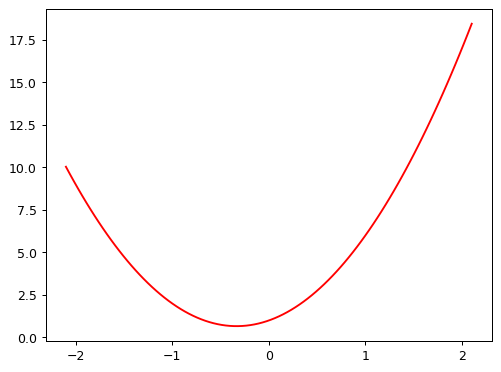

In [5]:
f2=mk_quad(3, 2, 1)
plotFunction(f2)

Lets simulate some noise

In [6]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1 + noise(x, mult)) + noise(x, add)

np.random.seed(42)
x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise(f(x), 0.15, 1.5)

C:\Users\k.krachmarov\AppData\Local\Temp\ipykernel_15704\3941506361.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  def add_noise(x, mult, add): return x * (1 + noise(x, mult)) + noise(x, add)


In [7]:
x[:5], y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304],
         [ 1.7947]], dtype=torch.float64))

Tensor is just an array in numpy. <br>
Tensor can be a single number (scalar, rank-0 tensor), list of numbers (vector, rank-1 tensor), table of numbers (matrix, rank-2 tensor), table of tables of numbers (rank-3 tensor) and etc.

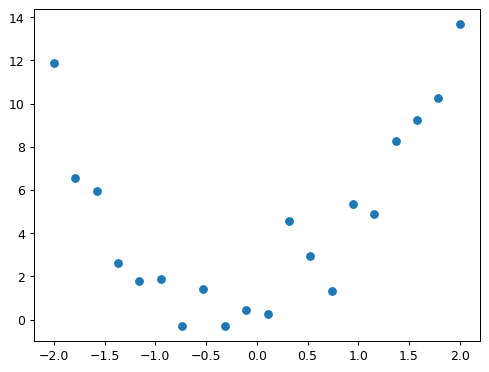

In [8]:
plt.scatter(x,y);

How do we find the values of a,b,c which fits the data.<br>
One way is  to overlay a quadratic on top of our data, with some sliders for a,b,c

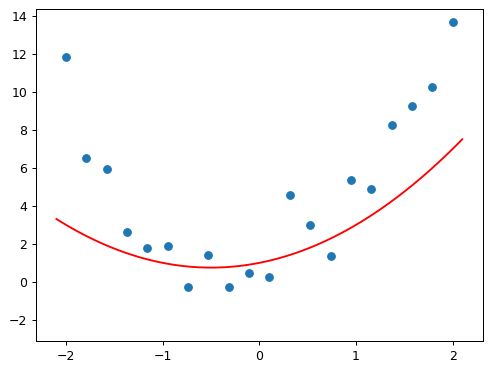

interactive(children=(IntSlider(value=1, description='a', max=3, min=-1), IntSlider(value=1, description='b', …

In [9]:
@interact(a=(1), b=(1), c=(1))
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plotFunction(mk_quad(a,b,c), ylim=(-3.13))


For some reason it doesnt work in jupyter lab <br>
You could just rerun the code with different values in the @interactive() but that is dumb af <br>
If it was to work the sliders whould have changed the parabola shape. <br>

We need a metric to measure how good is our fit. One easy metric is *mean absolute error* - distance from each data point to the curve

In [10]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

We'll update the intercative funtion, even thou it wont work

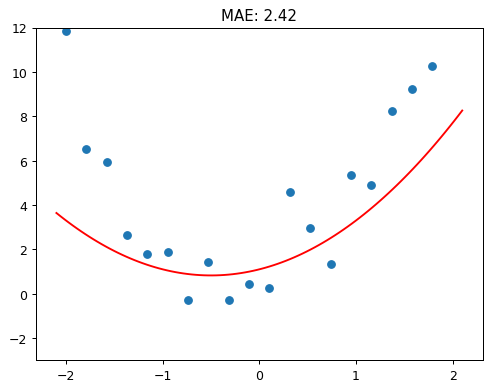

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [11]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x), y)
    plotFunction(f, ylim=(-3,12), title=f"MAE: {loss:.2f}")

In modern NN we have tens of milions of parameters and milions of data points. We cant do it with just moving some sliders. <br>
We can use calculus to automate the process and whenther we should increase or decrease a parameter. <br>

## Automating gradient descent

The basic idea: if we know the *gradient* of our ``` mae() ``` with respect to the parameters a,b,c then we know how one of the parameters will affect the mae. <br>
If a has negative gradient then we know that by increasing a the mae will decrease. <br>
We find the gradient of ``` mae() ``` for each parameter and we adjust a bit in the opposite direction to the sign of the gradient

In [12]:
def quad_mae(params):
    f=mk_quad(*params)
    return mae(f(x),y)

In [13]:
quad_mae([1.1, 1.1, 1.1])

tensor(2.4219, dtype=torch.float64)

We gonna do exactly like the manual. Pick some random starting points. We tell PyTorch that we want to calculate the gradient with ```.requires_grad_()```

In [14]:
abc=torch.tensor([1.1, 1.1, 1.1])
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

We calculate the mae. When doing gradient descent the thing we are trying to minimise is called *loss*

In [15]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

To calculate the gradient we use ```.backward() ```

In [16]:
loss.backward()

The gradient is stored in attribute called ```grad```

In [17]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

With these gradients all our parameters are low. Lets increase them. If we subtract the gradient multiplied by a small number we should improve them

In [18]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mae(abc)

print(f"loss={loss:.2f}")

loss=2.40


We need ```with torch.no_grad()``` because that dissables the calculation of the gradient in the context, because ``` abc -= abc.grad*0.01 ``` isn't part of the quadratic model, so we don't want the derivatives to include this calculation <br>
We can loop for a few more iterations

In [22]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad():
        abc-= abc.grad*0.01

    print(f'step={i}; loss={loss:.2f}') 

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


If we keep the loop running for long enough the loss will increase, because one of the parameter will get close tothe answer but it will jump over it. To avoid this we need to decrease the learning rate as we train. To do this we use *learning rate scedule* , and can be automated. 

## How a neural network approximates any given function

NN can be more convinient and powerfull. NN can approximate any computable function, given enough parameters. <br>
The way a NN approximates a function is very simple. The two key tricks are
1. Matrix multiplication
2. Function ```max(x, 0)``` which replaces all negative numbers with 0

In PyTorch ```max(x,0)``` is written as ```np.clip(x,0)```. The combination of a linear function and ```max()``` is called *linear rectified function*


In [25]:
def rectified_linear(m,b,x):
    y = m*x + b
    return torch.clip(y, 0.)

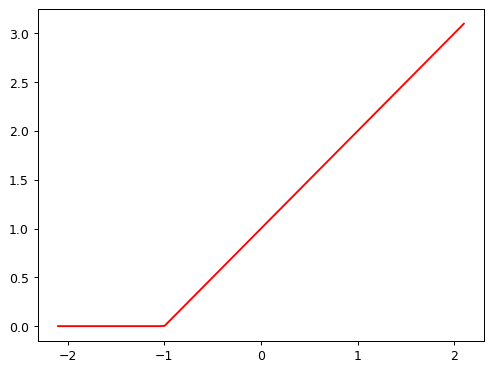

In [26]:
plotFunction(partial(rectified_linear, 1,1))

We can use ```F.relu(x)``` instead of ```torch.clip(y, 0.)```. ```F``` refers to ```torch.nn.functional``` module

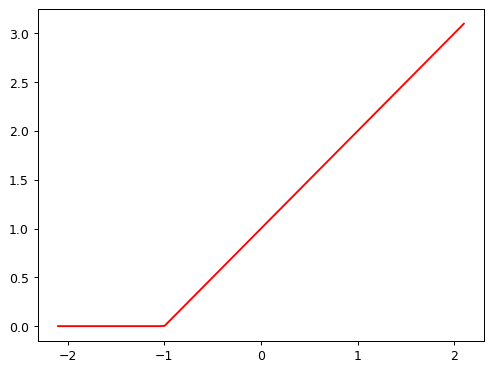

In [27]:
import torch.nn.functional as F
def rectified_linear2(m, b, x):
    return F.relu(m*x+1)

plotFunction(partial(rectified_linear2, 1,1))

To understand how it works try using interactive 

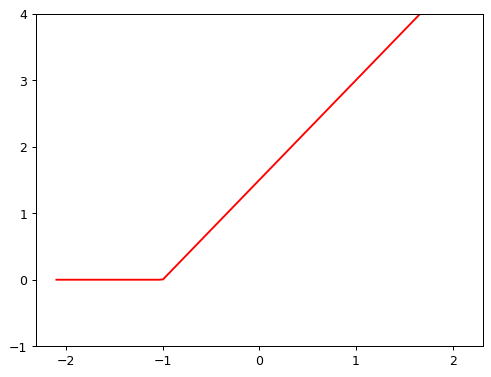

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [29]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plotFunction(partial(rectified_linear, m,b), ylim=(-1,4))